In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [3]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(100)
        price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
        price["volume_traded"] = price["volume"].rolling(100).mean() / price["adjclose"].rolling(100).mean()
        prices.append(price.dropna())
    except:
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:47<00:00, 10.61it/s]


In [4]:
prices = pd.concat(prices).sort_values("date")

In [5]:
prices.head()

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,...,splitfactor,year,quarter,month,week,weekday,ticker,average_return,coev,volume_traded
100,2004-11-23 00:00:00+00:00,80.24,80.75,80.05,80.74,2964100,37.873686,38.114408,37.784005,38.109688,...,1.0,2004,4,11,48,1,MMM,-0.074812,0.038422,80747.479953
100,2004-11-23 00:00:00+00:00,39.18,39.25,38.80,38.85,420800,4.353329,4.361107,4.311107,4.316662,...,1.0,2004,4,11,48,1,ACGL,-0.010106,0.031910,41920.763701
100,2004-11-23 00:00:00+00:00,28.95,29.44,28.60,28.64,3381867,9.650005,9.813338,9.533338,9.546671,...,1.0,2004,4,11,48,1,DLTR,0.088346,0.067501,167882.735107
100,2004-11-23 00:00:00+00:00,34.13,34.27,33.70,33.83,1190200,21.190984,21.277909,20.924002,21.004717,...,1.0,2004,4,11,48,1,PCG,0.203880,0.060795,91992.814578
100,2004-11-23 00:00:00+00:00,22.83,23.03,22.75,22.90,2131300,14.814648,14.944430,14.762735,14.860071,...,1.0,2004,4,11,48,1,A,-0.192430,0.073851,196143.729259


In [10]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(prices["date"].unique()):
    try:
        today = prices[prices["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"]:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4933/4933 [00:37<00:00, 130.95it/s]


In [11]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]
states["trade"] = states["ticker"] != states["ticker"].shift(-1)

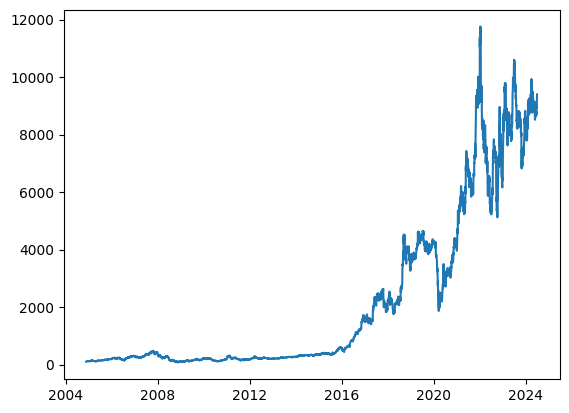

In [12]:
plt.plot(states["date"].values,states["pv"].values)

In [13]:
states[states["trade"]==True]

,ticker,adjclose,quantity,buy_price,date,pv,trade
302,NVDA,0.345984,668.106987,0.149677,2006-02-06 00:00:00+00:00,231.154239,True
329,AAPL,1.941630,109.228738,2.040961,2006-03-16 00:00:00+00:00,212.081787,True
330,NVDA,0.372816,571.961123,0.372816,2006-03-17 00:00:00+00:00,213.236019,True
331,AAPL,1.931969,109.535050,1.931969,2006-03-20 00:00:00+00:00,211.618276,True
333,NVDA,0.377096,526.478079,0.388257,2006-03-22 00:00:00+00:00,198.533001,True
366,AAPL,2.144518,111.342734,1.816334,2006-05-09 00:00:00+00:00,238.776535,True
1791,NVDA,0.325650,525.856061,0.451323,2012-01-04 00:00:00+00:00,171.244868,True
1888,BAC,5.813846,34.714645,5.110097,2012-05-23 00:00:00+00:00,201.825603,True
2987,NVDA,1.678534,723.683775,0.277720,2016-10-05 00:00:00+00:00,1214.727678,True
3045,BAC,18.867007,87.791211,13.656067,2016-12-28 00:00:00+00:00,1656.357384,True
